In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/exp6/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/exp6/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=8000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(8000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
print(len(word_to_index))

7997


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [9]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
word_to_index = {k:(v+3) for k, v in word_to_index.items()}

word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
word_to_index['<UNUSED>'] = 3

In [12]:
print(len(word_to_index))

8001


In [13]:
vocab_size = 8000
word_vector_dim = 16

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [14]:
print(X_train.shape)

(146182, 41)


In [15]:
x_val = X_train[:120000]   
y_val = y_train[:120000]

partial_x_train = X_train[120000:]  
partial_y_train = y_train[120000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(26182, 41)
(26182,)


In [16]:
model1 = Sequential()
model1.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model1.add(LSTM(16))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 130,689
Trainable params: 130,689
Non-trainable params: 0
_________________________________________________________________


In [17]:
model2 = Sequential()
model2.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model2.add(Conv1D(64, 7, activation = 'relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(16, 7, activation = 'relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          7232      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          7184      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 128,289
Trainable params: 128,289
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs=10

In [20]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
103/103 [==============================] - 5s 18ms/step - loss: 0.5938 - accuracy: 0.7261 - val_loss: 0.4362 - val_accuracy: 0.8103
Epoch 2/10
103/103 [==============================] - 1s 14ms/step - loss: 0.3725 - accuracy: 0.8383 - val_loss: 0.3844 - val_accuracy: 0.8298
Epoch 3/10
103/103 [==============================] - 1s 14ms/step - loss: 0.3117 - accuracy: 0.8720 - val_loss: 0.3991 - val_accuracy: 0.8249
Epoch 4/10
103/103 [==============================] - 1s 15ms/step - loss: 0.2789 - accuracy: 0.8861 - val_loss: 0.3987 - val_accuracy: 0.8278
Epoch 5/10
103/103 [==============================] - 1s 15ms/step - loss: 0.2585 - accuracy: 0.8965 - val_loss: 0.4214 - val_accuracy: 0.8246
Epoch 6/10
103/103 [==============================] - 1s 14ms/step - loss: 0.2396 - accuracy: 0.9049 - val_loss: 0.4631 - val_accuracy: 0.8159
Epoch 7/10
103/103 [==============================] - 1s 14ms/step - loss: 0.2295 - accuracy: 0.9107 - val_loss: 0.4590 - val_accuracy: 0.8194

In [22]:
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
205/205 [==============================] - 4s 13ms/step - loss: 0.6188 - accuracy: 0.6700 - val_loss: 0.5270 - val_accuracy: 0.8107
Epoch 2/10
205/205 [==============================] - 2s 12ms/step - loss: 0.4746 - accuracy: 0.8442 - val_loss: 0.4998 - val_accuracy: 0.8170
Epoch 3/10
205/205 [==============================] - 2s 12ms/step - loss: 0.4001 - accuracy: 0.8788 - val_loss: 0.5086 - val_accuracy: 0.8190
Epoch 4/10
205/205 [==============================] - 3s 13ms/step - loss: 0.3415 - accuracy: 0.9016 - val_loss: 0.4899 - val_accuracy: 0.8177
Epoch 5/10
205/205 [==============================] - 3s 12ms/step - loss: 0.2930 - accuracy: 0.9202 - val_loss: 0.5192 - val_accuracy: 0.8160
Epoch 6/10
205/205 [==============================] - 2s 12ms/step - loss: 0.2527 - accuracy: 0.9331 - val_loss: 0.5868 - val_accuracy: 0.8155
Epoch 7/10
205/205 [==============================] - 3s 12ms/step - loss: 0.2211 - accuracy: 0.9446 - val_loss: 0.5950 - val_accuracy: 0.8121

In [23]:
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
103/103 [==============================] - 1s 10ms/step - loss: 0.6733 - accuracy: 0.6639 - val_loss: 0.6270 - val_accuracy: 0.7643
Epoch 2/10
103/103 [==============================] - 1s 9ms/step - loss: 0.5342 - accuracy: 0.8017 - val_loss: 0.4644 - val_accuracy: 0.8023
Epoch 3/10
103/103 [==============================] - 1s 9ms/step - loss: 0.3935 - accuracy: 0.8424 - val_loss: 0.4035 - val_accuracy: 0.8188
Epoch 4/10
103/103 [==============================] - 1s 9ms/step - loss: 0.3227 - accuracy: 0.8719 - val_loss: 0.3890 - val_accuracy: 0.8251
Epoch 5/10
103/103 [==============================] - 1s 9ms/step - loss: 0.2765 - accuracy: 0.8908 - val_loss: 0.3903 - val_accuracy: 0.8270
Epoch 6/10
103/103 [==============================] - 1s 9ms/step - loss: 0.2401 - accuracy: 0.9075 - val_loss: 0.3977 - val_accuracy: 0.8273
Epoch 7/10
103/103 [==============================] - 1s 9ms/step - loss: 0.2100 - accuracy: 0.9224 - val_loss: 0.4120 - val_accuracy: 0.8262
Epoch

In [24]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.5352 - accuracy: 0.8103
[0.5351870656013489, 0.8103423714637756]


In [25]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.7301 - accuracy: 0.8056
[0.5351870656013489, 0.8103423714637756]


In [26]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 2s - loss: 0.4771 - accuracy: 0.8173
[0.5351870656013489, 0.8103423714637756]


In [27]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

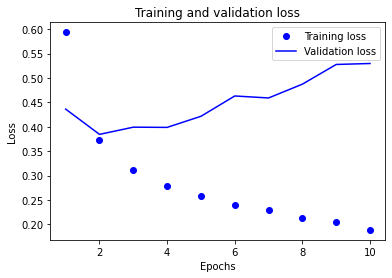

In [28]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

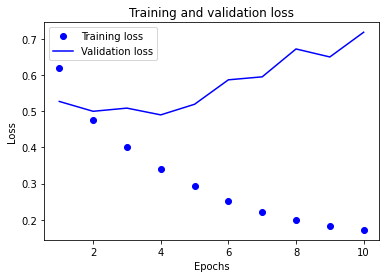

In [29]:
import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

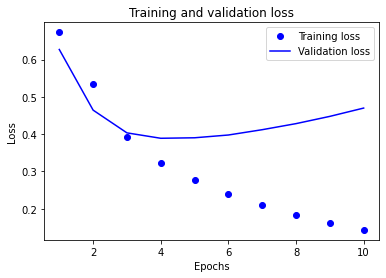

In [30]:
import matplotlib.pyplot as plt

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

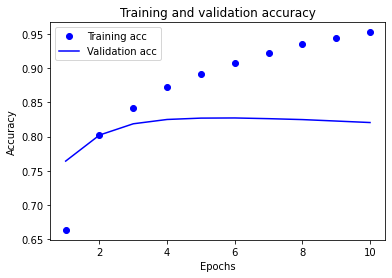

In [31]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Embedding


In [32]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(8000, 16)


In [33]:
word2vec_file_path = './data/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

8

In [34]:
vectors = model3.get_weights()[0]

In [35]:
print(len(vectors)), print(vocab_size)

8000
8000


(None, None)

In [36]:
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i,:])))))
f.close

<function TextIOWrapper.close()>

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [39]:
word_vectors.similar_by_word("이쁨")

[('질리', 0.9038172364234924),
 ('패닝', 0.8999847769737244),
 ('흐른다', 0.8766512274742126),
 ('박스', 0.8456798195838928),
 ('코끝', 0.8405992984771729),
 ('아픈', 0.8313291072845459),
 ('지나가', 0.8274398446083069),
 ('♥♥', 0.8145725727081299),
 ('전하', 0.8007568717002869),
 ('릴', 0.8007561564445496)]

# 한국어 Word2Vec 임베딩 활용하여 성능개선

In [40]:
import gensim
gensim.__version__

'3.8.1'

In [41]:
from gensim.models import KeyedVectors
word2vec_path = './ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector     

/tmp/ipykernel_4989/3673978347.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [42]:
vocab_size = len(word_vectors.vocab)
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

In [43]:
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4989/1786093199.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4989/1786093199.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [45]:
from tensorflow.keras.initializers import Constant

In [46]:
model3 = tf.keras.Sequential()
model3.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable = True))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           1594600   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,597,833
Trainable params: 1,597,833
Non-trainable params: 0
_________________________________________________________________


In [47]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
103/103 [==============================] - 2s 11ms/step - loss: 0.7208 - accuracy: 0.5565 - val_loss: 0.6583 - val_accuracy: 0.6135
Epoch 2/10
103/103 [==============================] - 1s 10ms/step - loss: 0.6284 - accuracy: 0.6479 - val_loss: 0.6107 - val_accuracy: 0.6679
Epoch 3/10
103/103 [==============================] - 1s 9ms/step - loss: 0.5865 - accuracy: 0.6911 - val_loss: 0.5808 - val_accuracy: 0.6963
Epoch 4/10
103/103 [==============================] - 1s 10ms/step - loss: 0.5547 - accuracy: 0.7162 - val_loss: 0.5584 - val_accuracy: 0.7126
Epoch 5/10
103/103 [==============================] - 1s 10ms/step - loss: 0.5236 - accuracy: 0.7410 - val_loss: 0.5383 - val_accuracy: 0.7303
Epoch 6/10
103/103 [==============================] - 1s 9ms/step - loss: 0.4985 - accuracy: 0.7570 - val_loss: 0.5230 - val_accuracy: 0.7410
Epoch 7/10
103/103 [==============================] - 1s 9ms/step - loss: 0.4697 - accuracy: 0.7762 - val_loss: 0.5084 - val_accuracy: 0.7507
Ep

In [51]:
results5 = model3.evaluate(X_test,  y_test, verbose=2)

print(results5)

1537/1537 - 2s - loss: 0.4891 - accuracy: 0.7672
[0.48911750316619873, 0.7672355771064758]


In [48]:
model4 = Sequential()
model4.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable = True))
model4.add(Dropout(0.2))
model4.add(LSTM(196, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
model4.add(LSTM(196, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
model4.add(MaxPooling1D())
model4.add(GlobalMaxPooling1D())
model4.add(Dense(784, activation='relu'))
model4.add(Dense(784, activation='relu'))

model4.add(Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           1594600   
_________________________________________________________________
dropout (Dropout)            (None, 41, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 196)           311248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 41, 196)           308112    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 196)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 196)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)              

In [50]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
103/103 [==============================] - 52s 469ms/step - loss: 0.5984 - accuracy: 0.6630 - val_loss: 0.5070 - val_accuracy: 0.7484
Epoch 2/10
103/103 [==============================] - 48s 464ms/step - loss: 0.4834 - accuracy: 0.7659 - val_loss: 0.4699 - val_accuracy: 0.7795
Epoch 3/10
103/103 [==============================] - 47s 462ms/step - loss: 0.4263 - accuracy: 0.8023 - val_loss: 0.4066 - val_accuracy: 0.8118
Epoch 4/10
103/103 [==============================] - 47s 461ms/step - loss: 0.3765 - accuracy: 0.8272 - val_loss: 0.4001 - val_accuracy: 0.8246
Epoch 5/10
103/103 [==============================] - 48s 463ms/step - loss: 0.3407 - accuracy: 0.8504 - val_loss: 0.3779 - val_accuracy: 0.8296
Epoch 6/10
103/103 [==============================] - 48s 465ms/step - loss: 0.3109 - accuracy: 0.8642 - val_loss: 0.3731 - val_accuracy: 0.8332
Epoch 7/10
103/103 [==============================] - 48s 463ms/step - loss: 0.2896 - accuracy: 0.8760 - val_loss: 0.4038 - val_ac

In [52]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 36s - loss: 0.4074 - accuracy: 0.8308
[0.4074268639087677, 0.8307870626449585]
